## remaining questions
- how to select hyperparameter range and step for grid search after first round of random search?
- how to conduct guided search (e.g., bayesian optimization)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
import random

In [3]:
train = pd.read_csv("train.csv")
train.info() # no NA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [4]:
test = pd.read_csv("test.csv")
test.info() # no NA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5271 non-null   int64  
 1   N_Days         5271 non-null   int64  
 2   Drug           5271 non-null   object 
 3   Age            5271 non-null   int64  
 4   Sex            5271 non-null   object 
 5   Ascites        5271 non-null   object 
 6   Hepatomegaly   5271 non-null   object 
 7   Spiders        5271 non-null   object 
 8   Edema          5271 non-null   object 
 9   Bilirubin      5271 non-null   float64
 10  Cholesterol    5271 non-null   float64
 11  Albumin        5271 non-null   float64
 12  Copper         5271 non-null   float64
 13  Alk_Phos       5271 non-null   float64
 14  SGOT           5271 non-null   float64
 15  Tryglicerides  5271 non-null   float64
 16  Platelets      5271 non-null   float64
 17  Prothrombin    5271 non-null   float64
 18  Stage   

## X - num cols

In [5]:
# num cols
num_cols = list(train.select_dtypes(include=["int64","float64"]).columns)
num_cols

['id',
 'N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

In [6]:
# train - inspect num cols for missing data
train_num_descr = train[num_cols].describe().transpose()
train_num_descr["num_na"] = train[num_cols].isna().sum()
train_num_descr

,count,mean,std,min,25%,50%,75%,max,num_na
id,7905.0,3952.000000,2282.121272,0.00,1976.00,3952.00,5928.00,7904.00,0
N_Days,7905.0,2030.173308,1094.233744,41.00,1230.00,1831.00,2689.00,4795.00,0
Age,7905.0,18373.146490,3679.958739,9598.00,15574.00,18713.00,20684.00,28650.00,0
Bilirubin,7905.0,2.594485,3.812960,0.30,0.70,1.10,3.00,28.00,0
Cholesterol,7905.0,350.561923,195.379344,120.00,248.00,298.00,390.00,1775.00,0
Albumin,7905.0,3.548323,0.346171,1.96,3.35,3.58,3.77,4.64,0
Copper,7905.0,83.902846,75.899266,4.00,39.00,63.00,102.00,588.00,0
Alk_Phos,7905.0,1816.745250,1903.750657,289.00,834.00,1181.00,1857.00,13862.40,0
SGOT,7905.0,114.604602,48.790945,26.35,75.95,108.50,137.95,457.25,0
Tryglicerides,7905.0,115.340164,52.530402,33.00,84.00,104.00,139.00,598.00,0


In [7]:
# test - inspect num cols for missing data
test_num_descr = test[num_cols].describe().transpose()
test_num_descr["num_na"] = test[num_cols].isna().sum()
test_num_descr

,count,mean,std,min,25%,50%,75%,max,num_na
id,5271.0,10540.000000,1521.750965,7905.00,9222.50,10540.00,11857.50,13175.00,0
N_Days,5271.0,2038.696642,1086.843490,41.00,1234.00,1882.00,2692.00,4795.00,0
Age,5271.0,18497.756782,3583.898801,9598.00,15730.00,18806.00,20684.00,28650.00,0
Bilirubin,5271.0,2.600389,3.852395,0.30,0.70,1.10,3.00,28.00,0
Cholesterol,5271.0,352.486435,200.438989,120.00,248.00,299.00,390.00,1775.00,0
Albumin,5271.0,3.538071,0.354886,1.96,3.35,3.57,3.77,4.64,0
Copper,5271.0,84.701679,77.542064,4.00,39.00,65.00,102.00,588.00,0
Alk_Phos,5271.0,1811.233314,1935.351492,289.00,823.00,1142.00,1838.50,13862.40,0
SGOT,5271.0,113.587526,48.964789,26.35,75.00,106.95,137.95,457.25,0
Tryglicerides,5271.0,115.286094,52.602780,33.00,84.00,104.00,138.00,598.00,0


In [8]:
# visualize distributions (does not incl. id)
kde_df = pd.concat([train[num_cols[1:]].assign(source="train"), 
                    test[num_cols[1:]].assign(source="test")],
                   axis=0,ignore_index=True)
kde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         13176 non-null  int64  
 1   Age            13176 non-null  int64  
 2   Bilirubin      13176 non-null  float64
 3   Cholesterol    13176 non-null  float64
 4   Albumin        13176 non-null  float64
 5   Copper         13176 non-null  float64
 6   Alk_Phos       13176 non-null  float64
 7   SGOT           13176 non-null  float64
 8   Tryglicerides  13176 non-null  float64
 9   Platelets      13176 non-null  float64
 10  Prothrombin    13176 non-null  float64
 11  Stage          13176 non-null  float64
 12  source         13176 non-null  object 
dtypes: float64(10), int64(2), object(1)
memory usage: 1.3+ MB


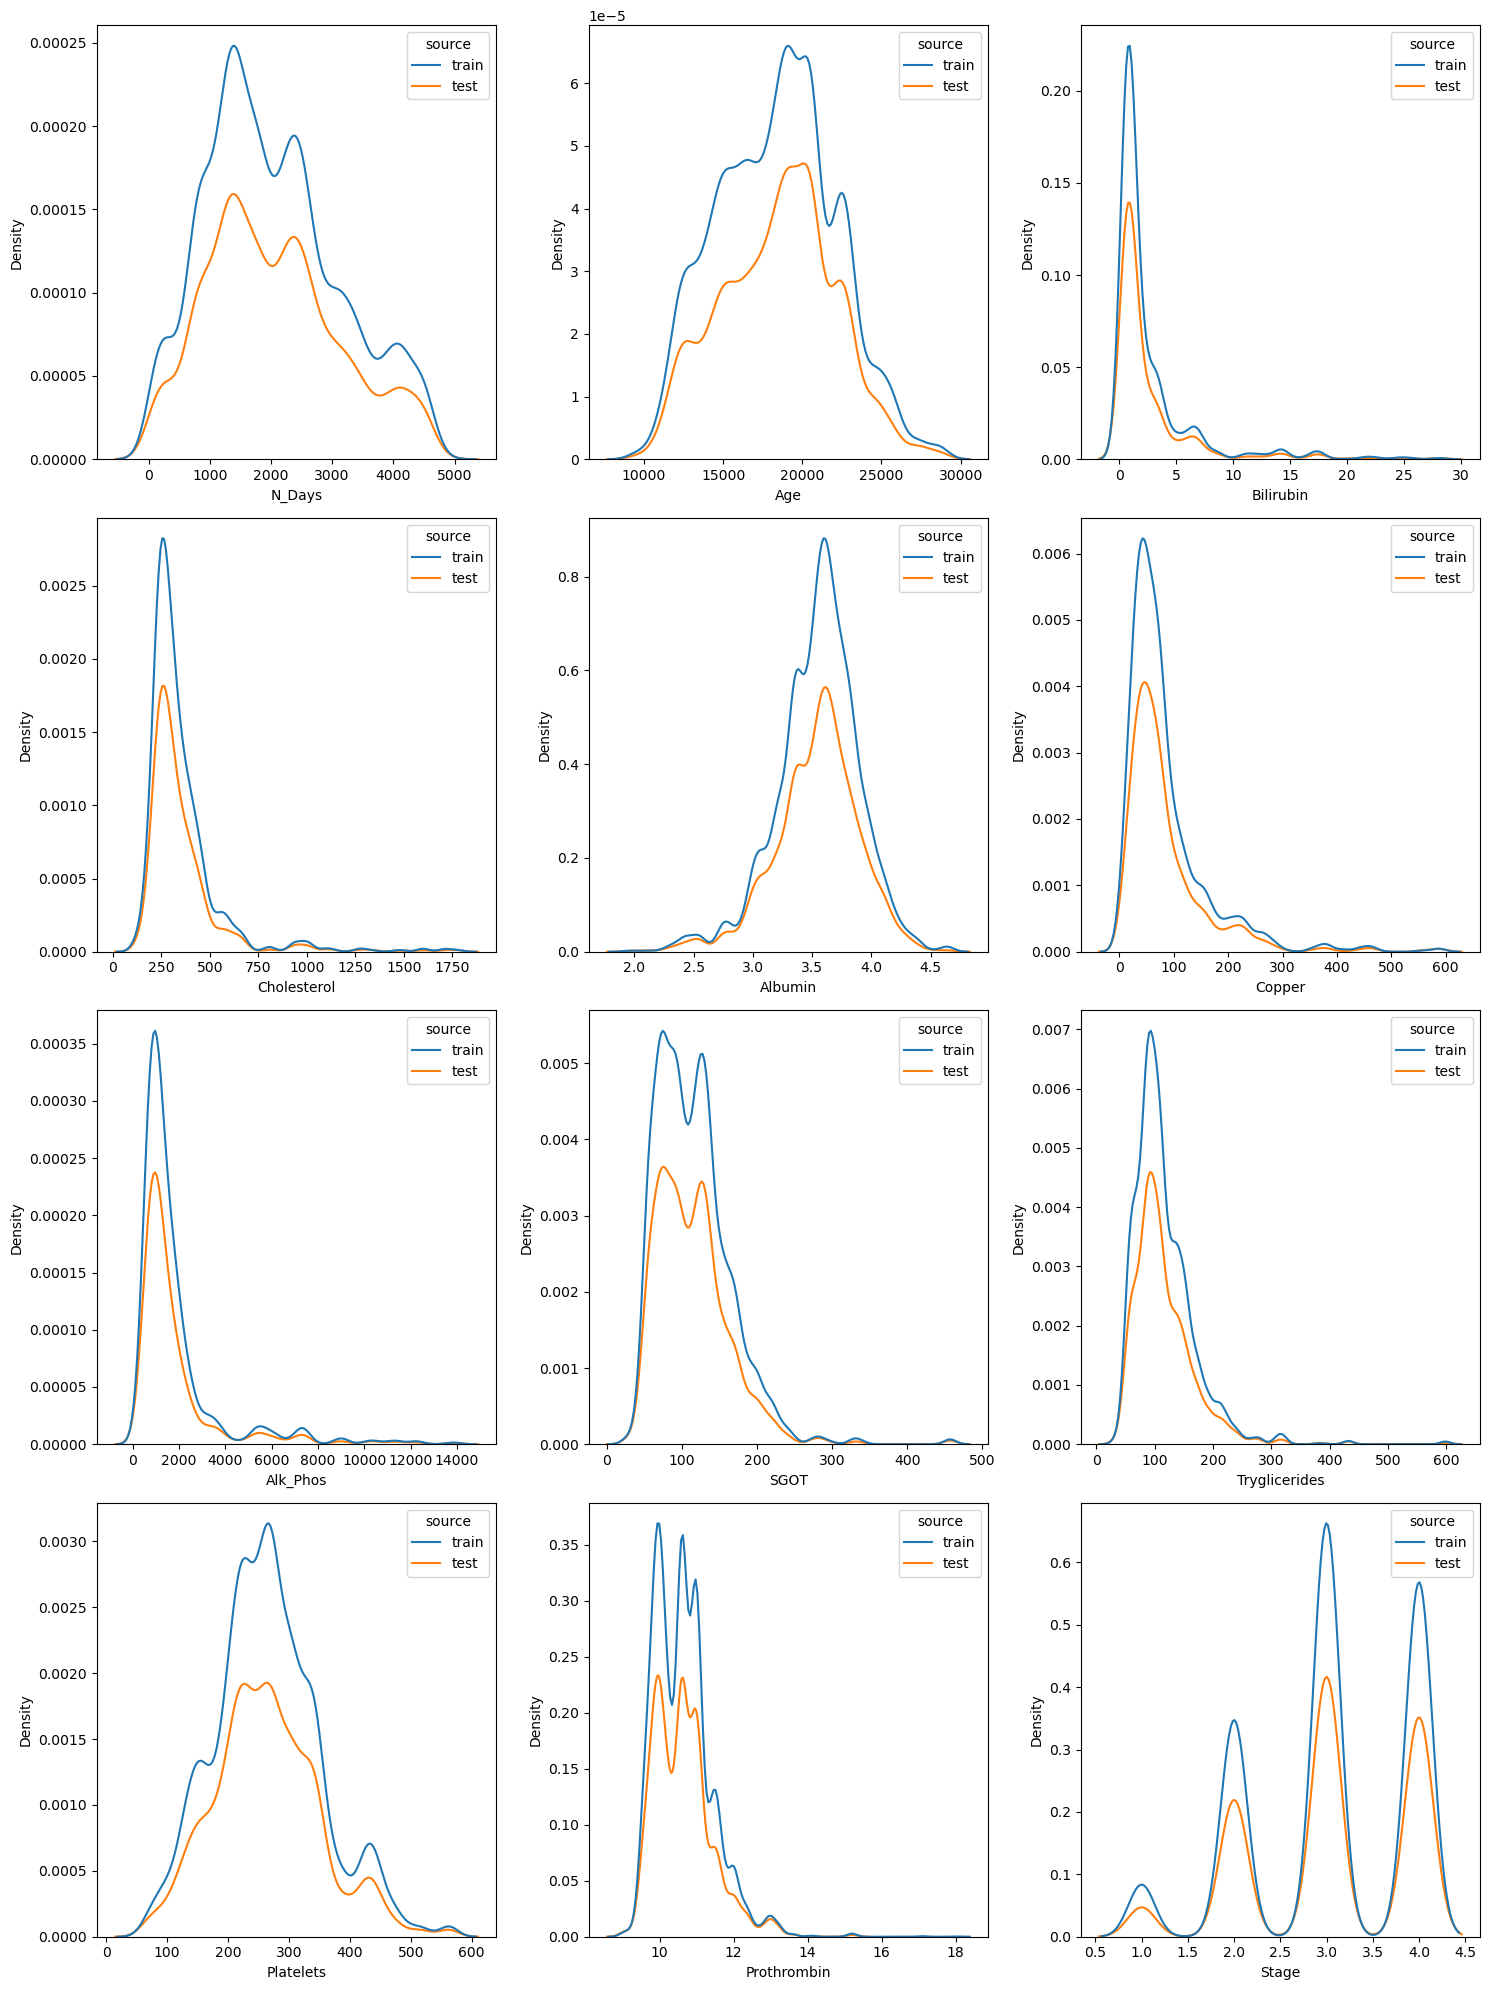

In [9]:
n_rows=4
n_cols=3
fig1, axes1 = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(15,20))
for i, column in enumerate(kde_df.drop(["source"],axis=1).columns):
    sns.kdeplot(x=kde_df[column],hue=kde_df["source"],
                ax=axes1[i//n_cols,i%n_cols])
plt.tight_layout()
# right skewed variables - Bilirubin, Colesterol, Copper, Alk_Phos, Tryglicerides, Prothrombinb

In [10]:
# calculate skewness in train
train_skew = train[num_cols[1:]].apply(lambda x:skew(x))
skewed_cols = list(train_skew[train_skew>=2].index)
skewed_cols
# right skewed variables - Bilirubin, Colesterol, Copper, Alk_Phos, Tryglicerides

['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'Tryglicerides']

In [11]:
# calculate skewness in test
test_skew = test[num_cols[1:]].apply(lambda x:skew(x))
list(test_skew[train_skew>=2].index) # same as train

['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'Tryglicerides']

In [12]:
# log transform cols with skew > 2 (on original dfs)
train[skewed_cols] = train[skewed_cols].apply(lambda x:np.log1p(x))
test[skewed_cols] = test[skewed_cols].apply(lambda x:np.log1p(x))

In [13]:
# rerun visualize distributions
kde_df = pd.concat([train[num_cols[1:]].assign(source="train"),
                    test[num_cols[1:]].assign(source="test")],
                   axis=0,ignore_index=True)
kde_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         13176 non-null  int64  
 1   Age            13176 non-null  int64  
 2   Bilirubin      13176 non-null  float64
 3   Cholesterol    13176 non-null  float64
 4   Albumin        13176 non-null  float64
 5   Copper         13176 non-null  float64
 6   Alk_Phos       13176 non-null  float64
 7   SGOT           13176 non-null  float64
 8   Tryglicerides  13176 non-null  float64
 9   Platelets      13176 non-null  float64
 10  Prothrombin    13176 non-null  float64
 11  Stage          13176 non-null  float64
 12  source         13176 non-null  object 
dtypes: float64(10), int64(2), object(1)
memory usage: 1.3+ MB


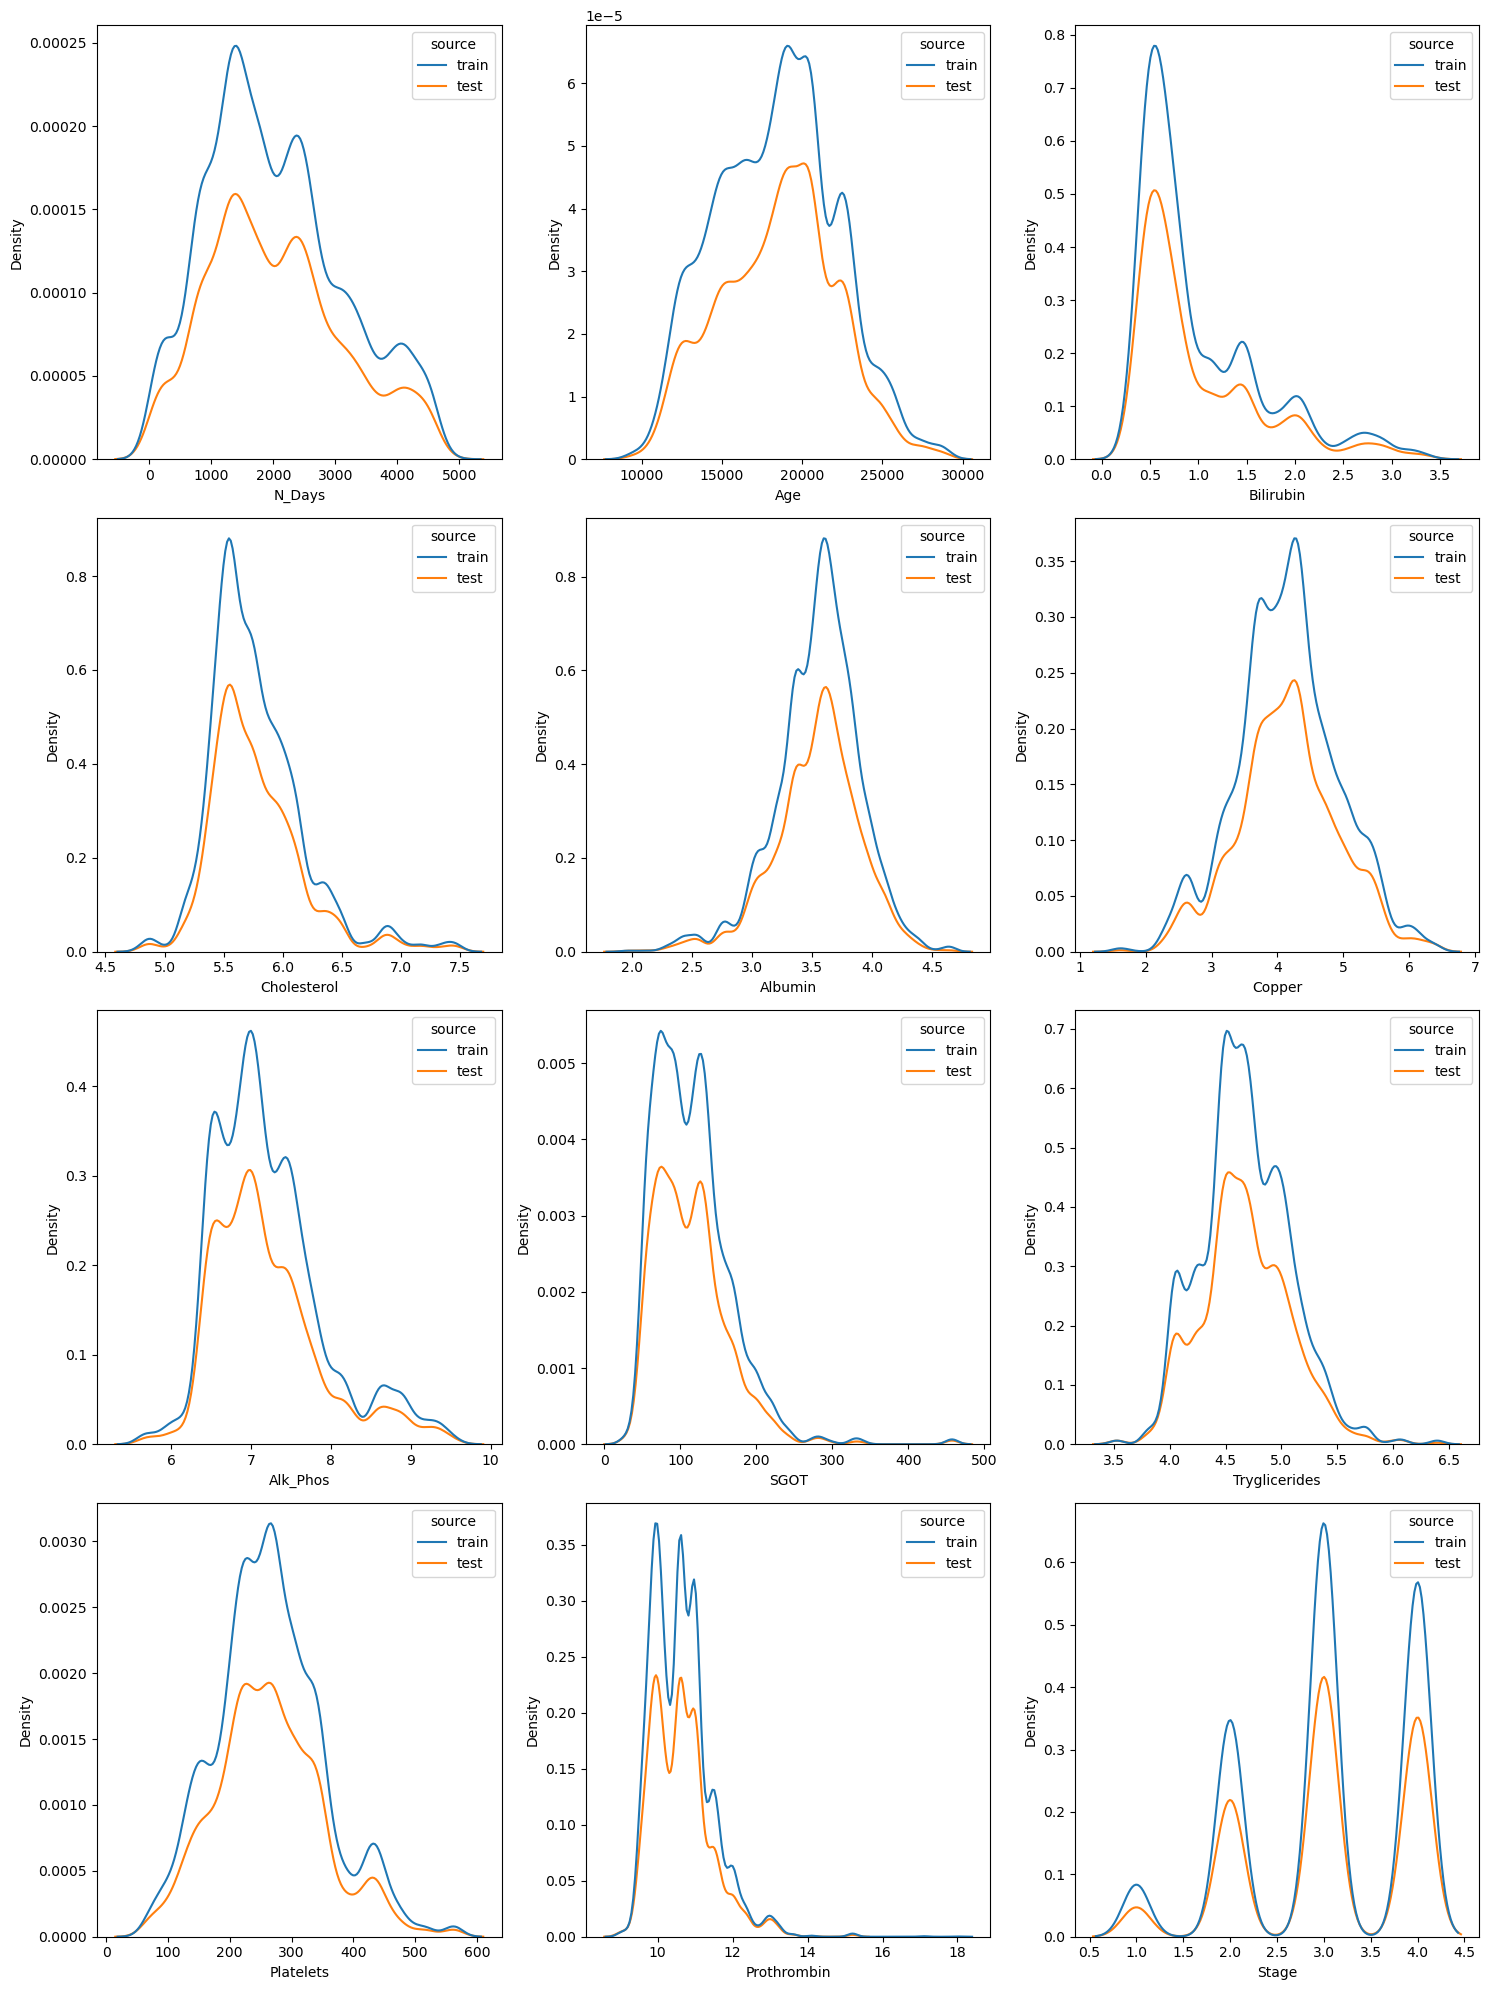

In [14]:
n_rows=4
n_cols=3
fig1, axes1 = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(15,20))
for i, column in enumerate(kde_df.drop(["source"],axis=1).columns):
    sns.kdeplot(x=kde_df[column],hue=kde_df["source"],
                ax=axes1[i//n_cols,i%n_cols])
plt.tight_layout()

### apply StandardScaler (stored in separate df)

In [15]:
sc = StandardScaler()
sc.fit(train[num_cols[1:]])

StandardScaler()

In [16]:
train_sc = pd.DataFrame(sc.transform(train[num_cols[1:]])) # array to df
train_sc.columns = train[num_cols[1:]].columns
train_sc

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,-0.942430,0.858448,0.300903,-0.030715,-0.572940,1.320759,0.242616,1.336304,-1.326915,1.472341,-1.189049,-0.037522
1,0.497025,0.234760,-0.550374,0.331176,-0.024043,0.014745,0.087759,0.414968,-0.481100,1.095026,0.474024,-0.037522
2,1.277529,-1.262634,0.709052,-0.172189,0.004846,0.965510,-0.403175,0.097266,-1.909316,-0.757248,1.369525,1.116605
3,0.498852,0.023603,-0.815363,-0.569272,-0.139601,-0.092091,0.289320,-0.887610,-0.260319,0.043117,0.090238,-0.037522
4,-1.135271,-0.466107,-0.396048,0.201372,0.293739,0.014745,-0.201921,0.224347,-0.260319,0.374697,-0.037691,1.116605
...,...,...,...,...,...,...,...,...,...,...,...,...
7900,-0.789802,-0.416919,-0.633744,-0.088028,0.033735,-0.635790,0.267950,-0.728759,1.897840,0.900652,-0.933192,-1.191649
7901,-0.491858,-0.364741,-0.550374,-0.529632,-0.341826,-0.005938,0.087759,0.561521,-0.786818,0.134588,-0.805263,1.116605
7902,-0.415087,2.038155,0.153937,-0.899197,-1.035169,-0.257960,-0.546221,-0.919380,-1.367310,-0.745814,2.648812,-1.191649
7903,1.420103,1.246520,-0.721881,-0.650439,-2.306298,-0.855192,-0.440555,-1.173542,0.263998,-0.505705,-0.037691,1.116605


In [17]:
test_sc = pd.DataFrame(sc.transform(test[num_cols[1:]])) # array to df
test_sc.columns = test[num_cols[1:]].columns
test_sc

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1.653158,0.367107,-0.324315,1.369533,-0.515161,0.055159,0.274215,0.764440,-0.424098,1.883958,-0.037691,-1.191649
1,0.400147,-0.923478,-0.396048,1.855420,1.940429,0.533513,-0.110811,0.764440,0.958425,-0.437102,-0.805263,-1.191649
2,-1.808844,-1.419711,0.153937,-1.917285,-1.699623,-0.390735,-0.503034,-0.919380,-0.131398,-0.597175,3.032598,1.116605
3,0.274023,0.580710,-0.815363,-0.224043,0.871525,-0.570108,-1.307244,0.224347,-1.624023,0.054551,-0.037691,-1.191649
4,-0.379443,0.959543,-0.190145,-0.367672,-1.670733,0.862042,-0.292493,0.213073,0.430885,-0.505705,-1.061120,-2.345776
...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.767551,-1.656141,-0.255771,-0.146650,-0.341826,0.240446,-0.011954,0.623012,-2.230359,-0.963057,-0.037691,-0.037522
5267,-0.237783,1.747373,-0.914880,-0.968260,1.564868,0.862042,-1.045073,-0.728759,-0.313759,0.523336,-1.189049,-0.037522
5268,1.532518,-0.375883,-0.633744,-0.038825,1.564868,-1.981331,0.275108,1.145683,-1.060677,1.838223,0.346095,-0.037522
5269,-0.744105,-1.793652,-0.721881,0.072442,0.727078,-0.232943,-1.012411,-1.180716,0.430885,0.466167,-0.549406,-2.345776


## X - obj cols

In [18]:
# obj cols
obj_cols = list(train.select_dtypes(include=["object"]).columns)
obj_cols

['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']

In [19]:
# train - inspect obj cols for mislabelled data
for col in obj_cols:
    print(col,"\n",train[col].unique()) # no mislabelled value

Drug 
 ['D-penicillamine' 'Placebo']
Sex 
 ['M' 'F']
Ascites 
 ['N' 'Y']
Hepatomegaly 
 ['N' 'Y']
Spiders 
 ['N' 'Y']
Edema 
 ['N' 'Y' 'S']
Status 
 ['D' 'C' 'CL']


In [20]:
# test - inspect obj cols for mislabelled data
for col in obj_cols[:-1]:
    print(col,"\n",test[col].unique()) # no mislabelled value

Drug 
 ['D-penicillamine' 'Placebo']
Sex 
 ['F' 'M']
Ascites 
 ['N' 'Y']
Hepatomegaly 
 ['Y' 'N']
Spiders 
 ['N' 'Y']
Edema 
 ['N' 'Y' 'S']


In [21]:
# visualize distributions (does not incl. Status)
bar_df = pd.concat([train[obj_cols[:-1]].assign(source="train"), 
                    test[obj_cols[:-1]].assign(source="test")],
                   axis=0,ignore_index=True)
bar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Drug          13176 non-null  object
 1   Sex           13176 non-null  object
 2   Ascites       13176 non-null  object
 3   Hepatomegaly  13176 non-null  object
 4   Spiders       13176 non-null  object
 5   Edema         13176 non-null  object
 6   source        13176 non-null  object
dtypes: object(7)
memory usage: 720.7+ KB


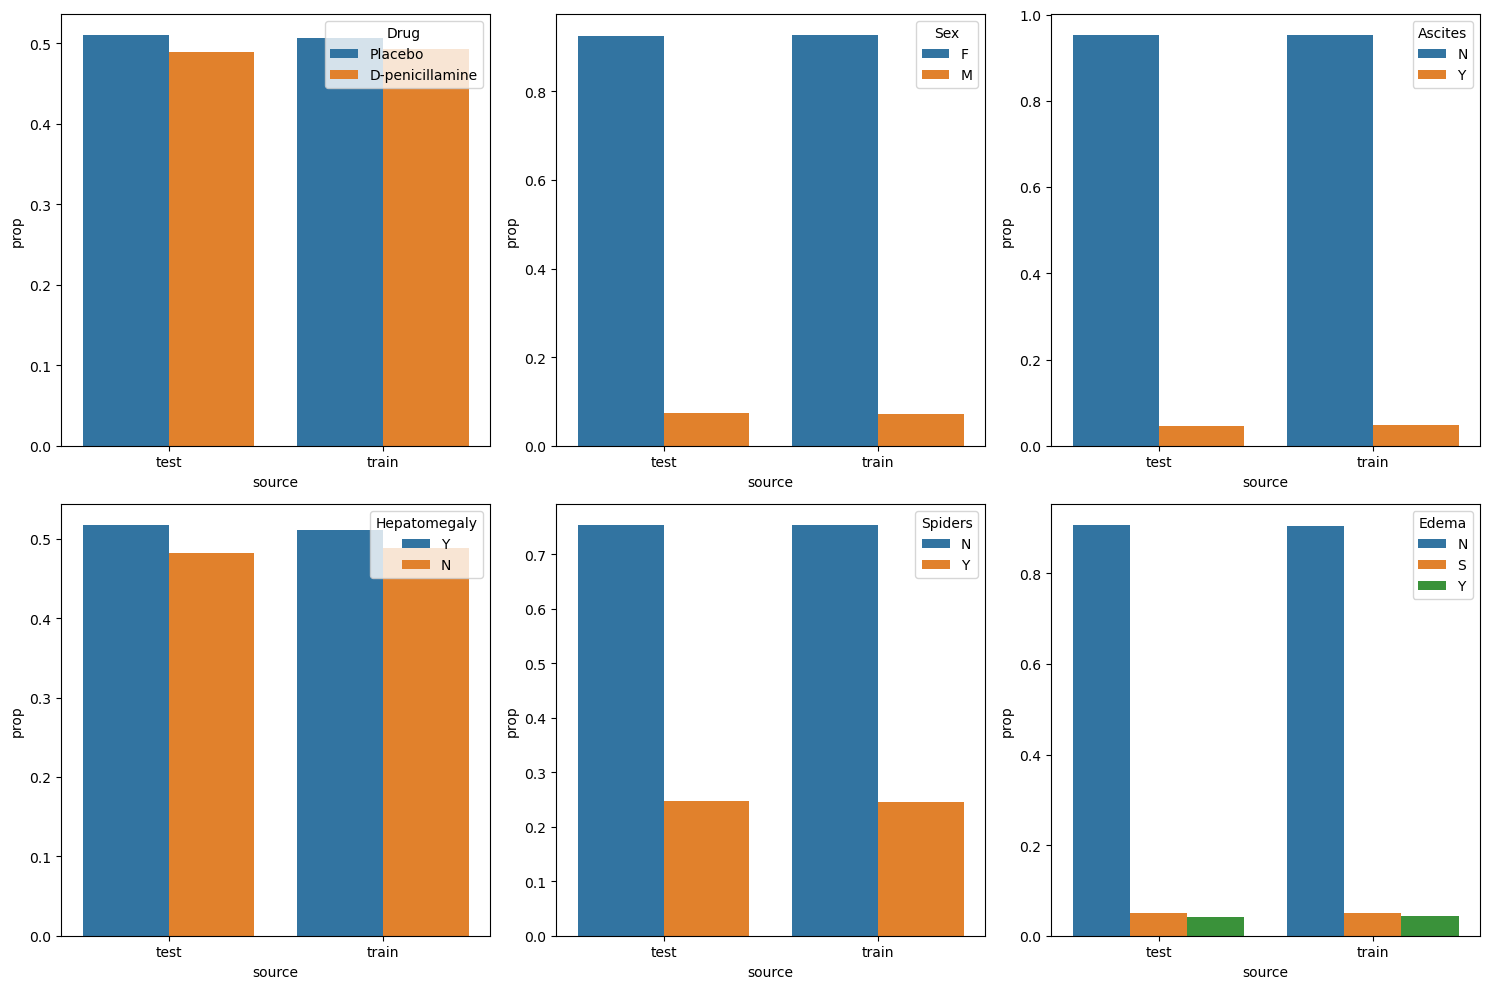

In [22]:
n_rows=2
n_cols=3
fig2, axes2 = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(15,10))
for i, column in enumerate(bar_df.drop(["source"],axis=1).columns):
    prop_df = bar_df[column].groupby(bar_df["source"]).value_counts(normalize=True).to_frame("prop").reset_index()
    sns.barplot(x="source",y="prop",hue=column,data=prop_df,ax=axes2[i//n_cols,i%n_cols])
plt.tight_layout() # train and test proportions are roughly the same

### apply OneHotEncoder (stored in separate df)

In [23]:
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(train[obj_cols[:-1]])
ohe.get_feature_names_out(obj_cols[:-1])

array(['Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F', 'Sex_M',
       'Ascites_N', 'Ascites_Y', 'Hepatomegaly_N', 'Hepatomegaly_Y',
       'Spiders_N', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y'],
      dtype=object)

In [24]:
train_ohe = pd.DataFrame(ohe.transform(train[obj_cols[:-1]]).toarray()) # sparse matrix, array, df
train_ohe.columns = ohe.get_feature_names_out(obj_cols[:-1])
train_ohe

,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
7901,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
7902,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7903,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [25]:
test_ohe = pd.DataFrame(ohe.transform(test[obj_cols[:-1]]).toarray()) # sparse matrix, array, df
test_ohe.columns = ohe.get_feature_names_out(obj_cols[:-1])
test_ohe

,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5267,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5268,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5269,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## X - correlation matrices

In [26]:
X_train = pd.concat([train_sc,train_ohe],axis=1)
X_train

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,-0.942430,0.858448,0.300903,-0.030715,-0.572940,1.320759,0.242616,1.336304,-1.326915,1.472341,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.497025,0.234760,-0.550374,0.331176,-0.024043,0.014745,0.087759,0.414968,-0.481100,1.095026,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.277529,-1.262634,0.709052,-0.172189,0.004846,0.965510,-0.403175,0.097266,-1.909316,-0.757248,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.498852,0.023603,-0.815363,-0.569272,-0.139601,-0.092091,0.289320,-0.887610,-0.260319,0.043117,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-1.135271,-0.466107,-0.396048,0.201372,0.293739,0.014745,-0.201921,0.224347,-0.260319,0.374697,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,-0.789802,-0.416919,-0.633744,-0.088028,0.033735,-0.635790,0.267950,-0.728759,1.897840,0.900652,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
7901,-0.491858,-0.364741,-0.550374,-0.529632,-0.341826,-0.005938,0.087759,0.561521,-0.786818,0.134588,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
7902,-0.415087,2.038155,0.153937,-0.899197,-1.035169,-0.257960,-0.546221,-0.919380,-1.367310,-0.745814,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7903,1.420103,1.246520,-0.721881,-0.650439,-2.306298,-0.855192,-0.440555,-1.173542,0.263998,-0.505705,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


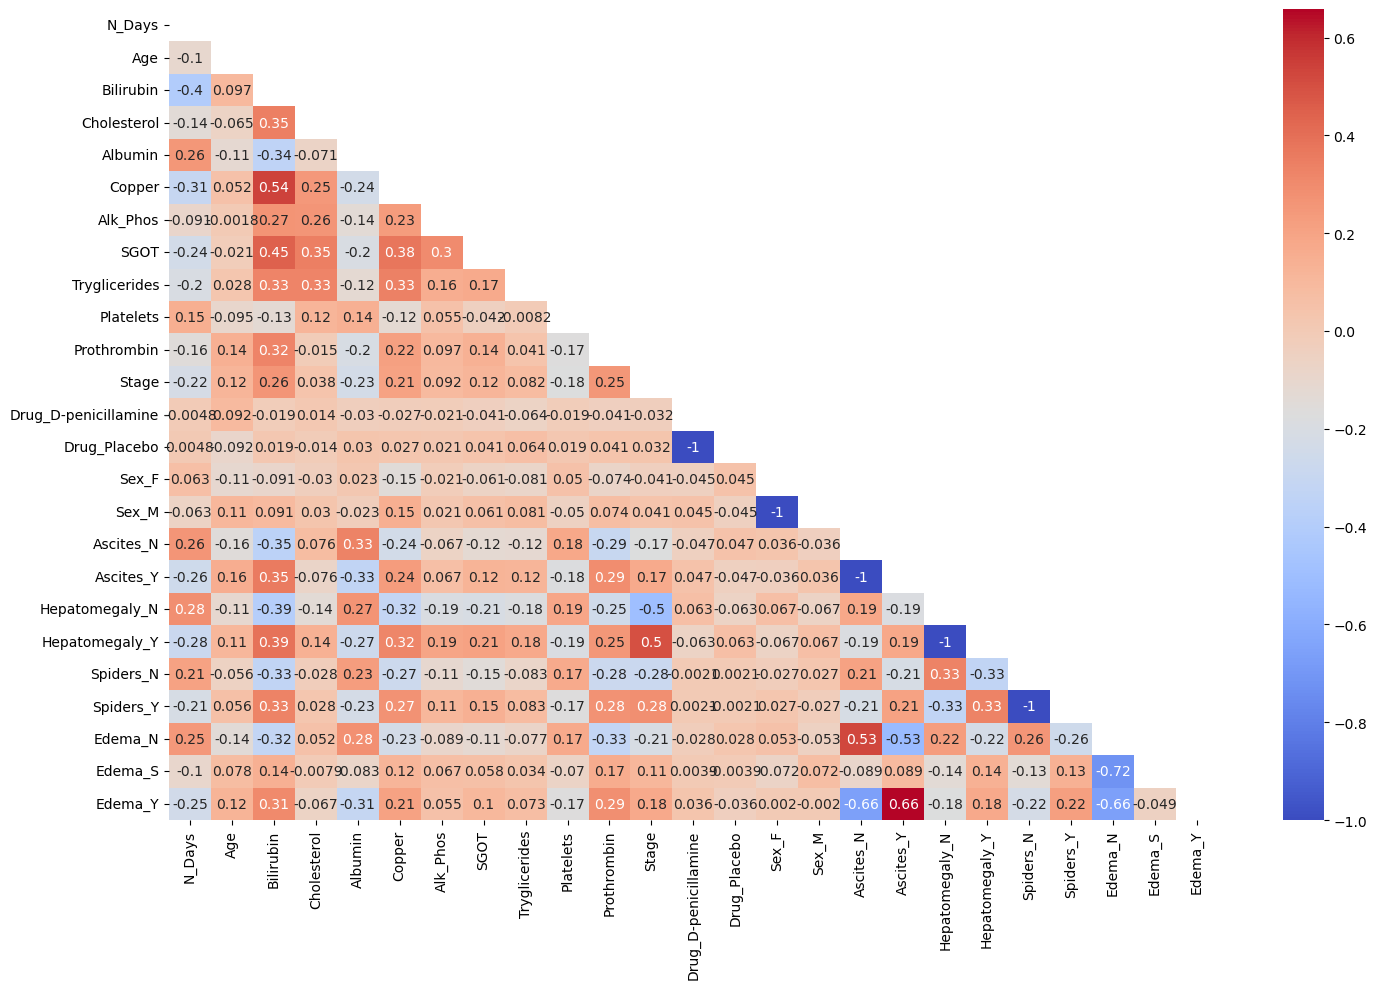

In [27]:
corr = X_train.corr()
mask = np.triu(corr)
fig3, axes3 = plt.subplots(figsize=(15,10))
sns.heatmap(corr,mask=mask,annot=True,cmap="coolwarm",ax=axes3)
plt.tight_layout()
plt.show() # no high values other than one hot encoded binary variablesb

In [28]:
X_test = pd.concat([test_sc,test_ohe],axis=1)
X_test

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,1.653158,0.367107,-0.324315,1.369533,-0.515161,0.055159,0.274215,0.764440,-0.424098,1.883958,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.400147,-0.923478,-0.396048,1.855420,1.940429,0.533513,-0.110811,0.764440,0.958425,-0.437102,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-1.808844,-1.419711,0.153937,-1.917285,-1.699623,-0.390735,-0.503034,-0.919380,-0.131398,-0.597175,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.274023,0.580710,-0.815363,-0.224043,0.871525,-0.570108,-1.307244,0.224347,-1.624023,0.054551,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.379443,0.959543,-0.190145,-0.367672,-1.670733,0.862042,-0.292493,0.213073,0.430885,-0.505705,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.767551,-1.656141,-0.255771,-0.146650,-0.341826,0.240446,-0.011954,0.623012,-2.230359,-0.963057,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5267,-0.237783,1.747373,-0.914880,-0.968260,1.564868,0.862042,-1.045073,-0.728759,-0.313759,0.523336,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5268,1.532518,-0.375883,-0.633744,-0.038825,1.564868,-1.981331,0.275108,1.145683,-1.060677,1.838223,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5269,-0.744105,-1.793652,-0.721881,0.072442,0.727078,-0.232943,-1.012411,-1.180716,0.430885,0.466167,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


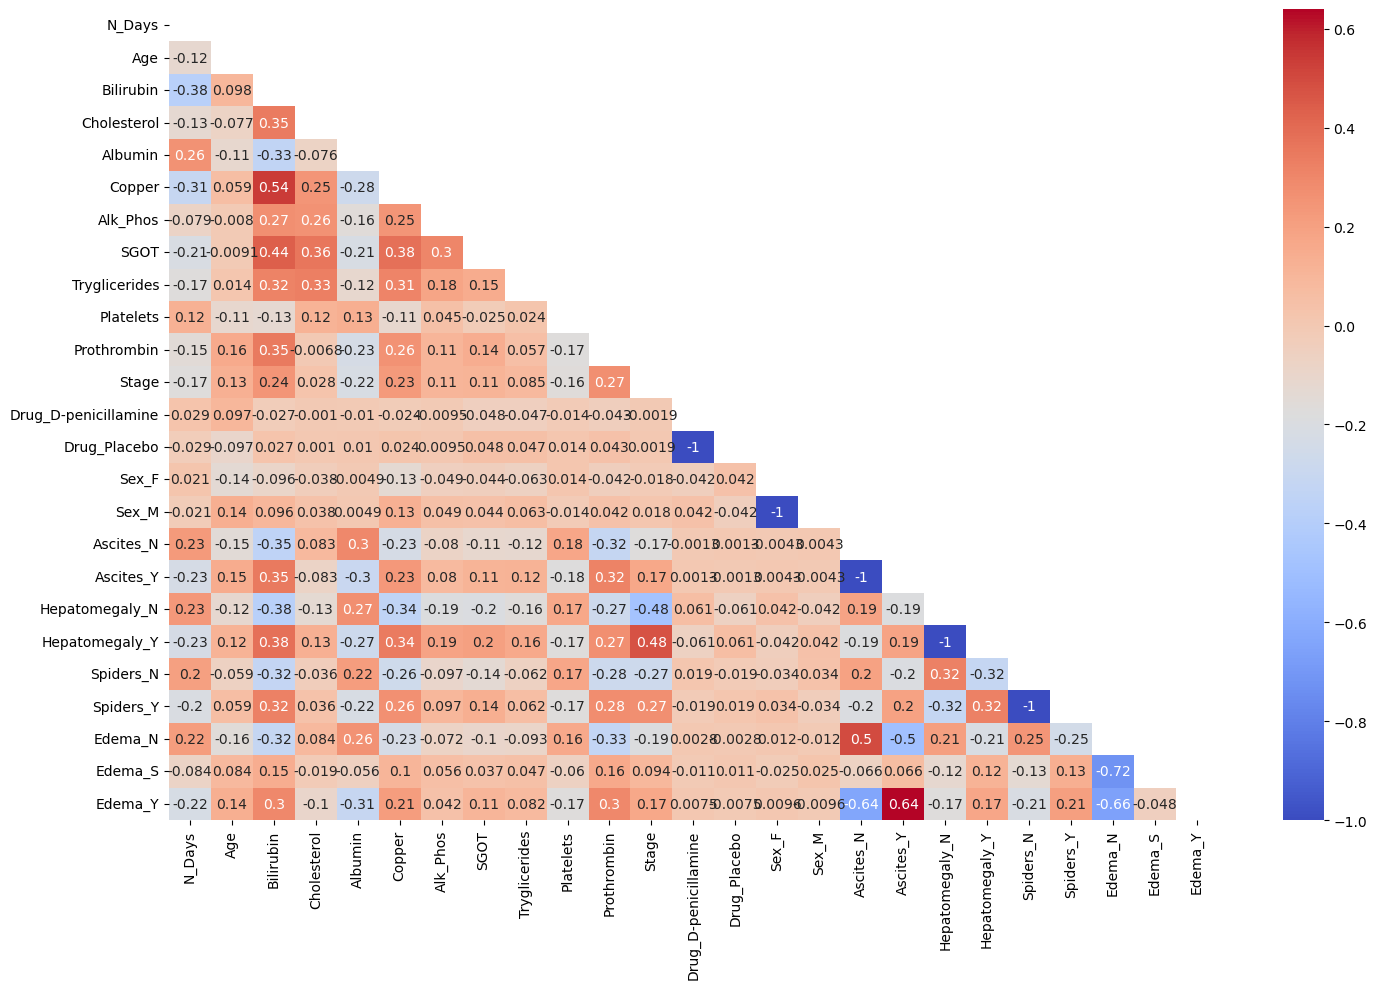

In [29]:
corr = X_test.corr()
mask = np.triu(corr)
fig4, axes4 = plt.subplots(figsize=(15,10))
sns.heatmap(corr,mask=mask,annot=True,cmap="coolwarm",ax=axes4)
plt.tight_layout()
plt.show() # no high values other than one hot encoded binary variablesb

## y - apply LabelEncoder (stored in separate df)

In [30]:
le = LabelEncoder()
le.fit(train["Status"])

LabelEncoder()

In [31]:
y_train_le = le.transform(train["Status"]) # array
y_train_le

array([2, 0, 2, ..., 2, 2, 0])

## set up cross validation

In [32]:
X_train.shape

(7905, 25)

In [33]:
y_train_le.shape

(7905,)

In [34]:
X_test.shape

(5271, 25)

In [35]:
def cross_validate(model):
    """
    cross-validate model with StratifiedKFold()
    """
    skf = StratifiedKFold(shuffle=True,random_state=20231212) # default n_splits=5
    oof_pred = np.full((len(X_train),3),np.nan)
    cross_entropy_list = []
    
    for fold,(idx_tr,idx_va) in enumerate(skf.split(X_train,y_train_le)):
        X_tr = X_train.iloc[idx_tr]
        X_va = X_train.iloc[idx_va]
        y_tr = y_train_le[idx_tr]
        y_va = y_train_le[idx_va]
        model.fit(X_tr,y_tr)
        y_va_pred = model.predict_proba(X_va)
        oof_pred[idx_va] = y_va_pred
        cross_entropy = log_loss(y_va,y_va_pred)
        cross_entropy_list.append(cross_entropy)
    
    mean_cross_entropy = round(np.array(cross_entropy_list).mean(),10)
    # each fold produces y_va_pred, oof_pred, cross_entropy
    # after all folds produces cross_entropy_list, mean_cross_entropy
    return mean_cross_entropy, model.get_params()

## baseline multinomial logistic regression model

In [36]:
mlr = cross_validate(LogisticRegression(multi_class="multinomial",random_state=20231212))
mlr
# 0.5165245092

/Users/lisiwang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lisiwang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

(0.5165267322,
 {'C': 1.0,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 100,
  'multi_class': 'multinomial',
  'n_jobs': None,
  'penalty': 'l2',
  'random_state': 20231212,
  'solver': 'lbfgs',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False})

## baseline lgbm model

In [37]:
lgbm = cross_validate(LGBMClassifier(random_state=20231221))
lgbm
# 0.4690187363

(0.4690187363,
 {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.1,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 100,
  'n_jobs': -1,
  'num_leaves': 31,
  'objective': None,
  'random_state': 20231221,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': 'warn',
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0})

## tune lgbm models - random search
inspired by https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search/notebook

In [38]:
# search domain
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [39]:
def random_search(param_grid, num_evals):
    """
    random search for hyperparameter tuning
    """
    # empty dataframe for results
    results = pd.DataFrame(columns = ['cross_entropy', 'hyper_params'], index = list(range(num_evals)))
    
    # keep searching until reach num_evals
    random.seed(20231231)
    for i in range(num_evals):
        
        # init random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # eval random hyperparameters
        cross_entropy, hyper_params = cross_validate(LGBMClassifier(**hyperparameters,random_state=20231231))
        results.loc[i, :] = cross_entropy, hyper_params
    
    # sort with lowest cross_entropy on top
    results.sort_values('cross_entropy', ascending = True, inplace = True)
    results.reset_index(inplace = True)
    return results

In [40]:
random_results = random_search(param_grid, num_evals = 1000)
random_results.head(10)

,index,cross_entropy,hyper_params
0,25,0.44176,"{'boosting_type': 'gbdt', 'class_weight': None..."
1,300,0.44329,"{'boosting_type': 'gbdt', 'class_weight': None..."
2,198,0.443475,"{'boosting_type': 'dart', 'class_weight': None..."
3,392,0.443586,"{'boosting_type': 'dart', 'class_weight': None..."
4,3,0.443741,"{'boosting_type': 'dart', 'class_weight': None..."
5,457,0.443753,"{'boosting_type': 'gbdt', 'class_weight': None..."
6,867,0.443998,"{'boosting_type': 'dart', 'class_weight': None..."
7,138,0.444009,"{'boosting_type': 'gbdt', 'class_weight': None..."
8,986,0.444217,"{'boosting_type': 'dart', 'class_weight': None..."
9,1,0.44425,"{'boosting_type': 'dart', 'class_weight': None..."


In [41]:
param_df = pd.DataFrame(random_results["hyper_params"].tolist())

In [42]:
param_df.head(10)[['num_leaves',
                   'learning_rate',
                   'subsample_for_bin',
                   'min_child_samples',
                   'reg_alpha',
                   'reg_lambda',
                   'colsample_bytree',
                   'subsample']].describe().loc[['min','max']]

,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample
min,27.0,0.036461,20000.0,40.0,0.061224,0.020408,0.600000,0.550505
max,144.0,0.225229,260000.0,225.0,1.000000,1.000000,0.777778,0.989899


In [43]:
for col in ['boosting_type','is_unbalance']:
    print(col,"\n",param_df.head(10)[col].unique())

boosting_type 
 ['gbdt' 'dart']
is_unbalance 
 [False  True]


In [44]:
# search domain (updated after one round of random_search)
param_grid_1 = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': list(range(27, 145)),
    'learning_rate': list(np.logspace(np.log10(0.02), np.log10(0.24), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 280000, 20000)),
    'min_child_samples': list(range(40, 230, 5)),
    'reg_alpha': list(np.linspace(0.06, 1)),
    'reg_lambda': list(np.linspace(0.02, 1)),
    'colsample_bytree': list(np.linspace(0.6, 0.8, 10)),
    'subsample': list(np.linspace(0.55, 1, 100)),
    'is_unbalance': [True, False]
}

In [45]:
random_results_1 = random_search(param_grid_1, num_evals = 1000)
random_results_1.head(10)

,index,cross_entropy,hyper_params
0,589,0.440398,"{'boosting_type': 'gbdt', 'class_weight': None..."
1,137,0.440791,"{'boosting_type': 'gbdt', 'class_weight': None..."
2,109,0.44081,"{'boosting_type': 'gbdt', 'class_weight': None..."
3,938,0.440826,"{'boosting_type': 'gbdt', 'class_weight': None..."
4,560,0.440921,"{'boosting_type': 'dart', 'class_weight': None..."
5,765,0.440928,"{'boosting_type': 'gbdt', 'class_weight': None..."
6,182,0.440956,"{'boosting_type': 'gbdt', 'class_weight': None..."
7,358,0.440968,"{'boosting_type': 'gbdt', 'class_weight': None..."
8,639,0.441301,"{'boosting_type': 'gbdt', 'class_weight': None..."
9,893,0.441326,"{'boosting_type': 'gbdt', 'class_weight': None..."


In [46]:
random_results_1.loc[0, "cross_entropy"]
# 0.4403977681

0.4403977681

In [47]:
random_hyper_params = random_results_1.loc[0, 'hyper_params']
random_hyper_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'learning_rate': 0.054092194216355374,
 'max_depth': -1,
 'min_child_samples': 90,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 129,
 'objective': None,
 'random_state': 20231231,
 'reg_alpha': 0.5587755102040816,
 'reg_lambda': 0.52,
 'silent': 'warn',
 'subsample': 0.8909090909090909,
 'subsample_for_bin': 140000,
 'subsample_freq': 0,
 'is_unbalance': False}

In [48]:
random_results_1.to_csv("random_results_20240101.csv",index=False)

## fit tuned lgbm model

In [50]:
# fit, train, test model
model = LGBMClassifier(**random_hyper_params)
model.fit(X_train, y_train_le)
y_test_pred = model.predict_proba(X_test)

In [55]:
y_test_pred[:10,:]

array([[5.40307015e-01, 2.64816899e-02, 4.33211295e-01],
       [6.74138268e-01, 1.70842334e-01, 1.55019398e-01],
       [2.45482046e-02, 1.15394474e-02, 9.63912348e-01],
       [9.58221393e-01, 5.22609153e-03, 3.65525155e-02],
       [8.49377876e-01, 1.75799034e-02, 1.33042220e-01],
       [9.92106927e-01, 1.56715884e-03, 6.32591401e-03],
       [9.83833095e-01, 9.30931647e-04, 1.52359736e-02],
       [1.75244744e-01, 1.04583243e-02, 8.14296932e-01],
       [1.50595359e-02, 1.48228552e-03, 9.83458179e-01],
       [5.47579963e-01, 1.75210021e-02, 4.34899035e-01]])

In [60]:
y_test_pred_df = pd.concat([test['id'],
                            pd.DataFrame(y_test_pred,columns=['Status_C', 'Status_CL', 'Status_D'])],
                           axis=1)
y_test_pred_df.head(10)

,id,Status_C,Status_CL,Status_D
0,7905,0.540307,0.026482,0.433211
1,7906,0.674138,0.170842,0.155019
2,7907,0.024548,0.011539,0.963912
3,7908,0.958221,0.005226,0.036553
4,7909,0.849378,0.017580,0.133042
5,7910,0.992107,0.001567,0.006326
6,7911,0.983833,0.000931,0.015236
7,7912,0.175245,0.010458,0.814297
8,7913,0.015060,0.001482,0.983458
9,7914,0.547580,0.017521,0.434899


In [ ]:
y_test_pred_df.to_csv("y_test_pred_df_20240101.csv",index=False)

y_test_pred_df_20231231.csv
0.4421671665
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'learning_rate': 0.04830087399761322,
 'max_depth': -1,
 'min_child_samples': 110,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 141,
 'objective': None,
 'random_state': 20231231,
 'reg_alpha': 0.8775510204081632,
 'reg_lambda': 0.42857142857142855,
 'silent': 'warn',
 'subsample': 0.5555555555555556,
 'subsample_for_bin': 120000,
 'subsample_freq': 0,
 'is_unbalance': True}

y_test_pred_df_20240101.csv
0.4403977681
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'learning_rate': 0.054092194216355374,
 'max_depth': -1,
 'min_child_samples': 90,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 129,
 'objective': None,
 'random_state': 20231231,
 'reg_alpha': 0.5587755102040816,
 'reg_lambda': 0.52,
 'silent': 'warn',
 'subsample': 0.8909090909090909,
 'subsample_for_bin': 140000,
 'subsample_freq': 0,
 'is_unbalance': False}

In [ ]:
#def grid_search(param_grid, num_evals):
    #"""grid search for hyperparameter tuning"""
    # empty dataframe for results
    #results = pd.DataFrame(columns = ['cross_entropy', 'hyper_params'], index = list(range(num_evals)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    #keys, values = zip(*param_grid.items()) 
    #i = 0
    
    # iterate through every possible combination of hyperparameters
    #for v in itertools.product(*values):
        
        # create a hyperparameter dictionary
        #hyperparameters = dict(zip(keys, v))
        
        # set the subsample ratio accounting for boosting type
        #hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # eval the hyperparameters
        #cross_entropy, hyper_params = cross_validate(LGBMClassifier(**hyperparameters,random_state=20231231))
        #results.loc[i, :] = cross_entropy, hyper_params
        #i += 1
        
        # normally would not limit iterations
        #if i > num_evals:
            #break
       
    # sort with lowest cross_entropy on top
    #results.sort_values('cross_entropy', ascending = True, inplace = True)
    #results.reset_index(inplace = True)
    #return results